In [7]:
import numpy as np
import itertools
import time

In [8]:
class RBM:
    def __init__(self, v_dim, h_dim, lr=10e-2, gibbs_num=1):
        self.v_dim = v_dim
        self.h_dim = h_dim
        self.lr = lr
        self.v_bias = np.random.normal(-0.1, 0.1, size = (1,self.v_dim))
        self.h_bias = np.random.normal(-0.1, 0.1, size =(1,self.h_dim))
        self.W = np.random.normal(size = (self.v_dim, self.h_dim))
        self.gibbs_num = gibbs_num
        self.v_w, self.v_v, self.v_h = 0, 0, 0
        self.momentum = 0.9

    
    # when a input vector V is recieved, p(h=1|v) can be computed
    # using the activition probability, the states of hidden layer could be sampled
    def sample_h(self, v_input):
        p_h_v = 1/(1 + np.exp(-(np.dot(v_input, self.W) + self.h_bias)))
        state_h = self.state_sample(p_h_v)

        return state_h, p_h_v
    
    # in constract, once the states of hidden layer are obtained, p(v=1|h) can be computed
    # with probability, the states of visible layer could be sampled 
    def sample_v(self, h):
        p_v_h = 1/(1 + np.exp(-(np.dot(h, self.W.T) + self.v_bias)))
        state_v = self.state_sample(p_v_h)
        
        return state_v, p_v_h

    def state_sample(self, p):
        state = []
        uni = np.random.uniform(0,1, size=p[0].shape[0])
        for i in range(len(p)):
            condition = np.less(p[i], uni)
            state_node = np.where(condition, 0, 1)
            state.append(state_node)
        return np.array(state).reshape(p.shape[0], p.shape[1])

    # taking use of the visible layer state V(i) and probability p(v|h), k'th V state could be computed 
    # and its corresponding p(h(k)|V).
    def gibbs_sampling(self, v):
        i = 0 
        k = self.gibbs_num
        v_0 = v

        _, p_h0_v = self.sample_h(v_0)

        while bool(i < k):
            state_h, _ = self.sample_h(v)
            state_v, _ = self.sample_v(state_h)
            i += 1
            #state_v[v0 < 0] = v_0[v0 < 0]
        else: 
            v_k = state_v
            #v_k[v0 < 0] = v_0[v0 < 0]
            _, p_hk_v = self.sample_h(v_k)
        
        return v_0, v_k, p_h0_v, p_hk_v
        

    # with the refered formulas, the gradient of each parameter(W, b-->h, a-->v) could be computed
    def gradient_compute(self, v_0, v_k, p_h0_v, p_hk_v):
        dw = np.dot(v_0.T, p_h0_v) - np.dot(v_k.T, p_hk_v)
        dh_bias = np.sum(p_h0_v - p_hk_v)
        dv_bias = np.sum(v_0 - v_k)
        
        
        self.v_w = self.momentum * self.v_w + (1 - self.momentum) * dw
        self.v_h = self.momentum * self.v_h + (1 - self.momentum) * dh_bias
        self.v_v = self.momentum * self.v_v + (1 - self.momentum) * dv_bias 

        self.W += self.lr * self.v_w
        self.v_bias += self.lr * self.v_v
        self.h_bias += self.lr * self.v_h 
    # set the number of iteration and go over all the training data (binary vectors) for one epoch.

In [9]:
def compute_px_with_Z(train_data, W, v_bias, h_bias): 
    probability = []
    for l in range(len(train_data)):
        train_data_one_piece = train_data[l]
        product_value = 1
        exp_av = np.exp(np.dot(v_bias, train_data_one_piece))
        for i in range(h_bias.shape[1]):
            product_value = product_value * (np.exp(np.dot(W.T[i], train_data_one_piece) + h_bias.T[i]) + 1)
        px_with_Z = exp_av * product_value
        probability.append(px_with_Z[0])
    return probability


def compute_Z(v_dim, W, v_bias, h_bias):
    def dic_build(dic_candidate, dim):
        i= 0
        for item in itertools.product('01',repeat=dim):
            if i not in dic_candidate:
                dic_candidate[i] = item
            i += 1
        return dic_candidate
        
    dic_v = {}  
    dic_v = dic_build(dic_v, v_dim)

    Z = 0
    for l in range(len(dic_v)):
        train_data_one = np.array(dic_v[l]).astype(int)
        exp_av = np.exp(np.dot(v_bias, train_data_one))
        product = 1
        for j in range(h_bias.shape[1]):
            product = product * (np.exp(np.dot(train_data_one.T, W.T[j]) + h_bias.T[j]) + 1)
        total = exp_av * product

        Z += total
    return Z

In [10]:
train_data = np.loadtxt(r'3x3.txt')

visible_node_num = train_data.shape[1]
hidden_node_num = 20
lr = 5e-4
gibbs_num = 1

epochs = 10000
batch_size = 1

In [11]:
rbm = RBM(visible_node_num, hidden_node_num, lr, gibbs_num)

In [12]:
KL_list = []
log_LKH_list = []

for epoch in range(epochs):
    epoch_start_time = time.time()
    for index in range(0, train_data.shape[0]-batch_size, batch_size):
        v0 = train_data[index: index + batch_size]
        vk = train_data[index: index + batch_size]
        _, p_h0_v = rbm.sample_h(v0)
        v0, vk, p_h0_v, p_hk_v = rbm.gibbs_sampling(v0)
        rbm.gradient_compute(v0, vk, p_h0_v, p_hk_v)
    

    Z = compute_Z(train_data.shape[1], rbm.W, rbm.v_bias, rbm.h_bias) 
    probability_list = compute_px_with_Z(train_data, rbm.W, rbm.v_bias, rbm.h_bias)

    logLKH = 0
    KL = 0
    
    
    for i in range(len(probability_list)):
        px_with_Z = probability_list[i]
        N = len(probability_list)
        log_lkh = np.log(px_with_Z) - np.log(Z) 
        logLKH += log_lkh

        kl = -np.log(N)/N - np.log(px_with_Z)/N + np.log(Z)/N
        KL += kl
    KL /= N
    logLKH /= N
    KL_list.append(KL)
    log_LKH_list.append(logLKH)

    probability_list = [probability_list[i]/Z for i in range(len(probability_list))]
    x = np.sum(probability_list)
    
    epoch_end_time = time.time()
    
    results = 'epoch:{} ==>  KL = {}, logLKH = {}, prob_sum = {:.4f}, time = {:.2f}s'.format(epoch+1, KL, logLKH, x, epoch_end_time-epoch_start_time)
    #f=open("log 0&1.txt","a")
    #f.write(results + '\n')
    #f.close()

    if(epoch % 100 == 0):
        print(results)


epoch:1 ==>  KL = [0.63421932], logLKH = [-11.51812783], prob_sum = 0.0015, time = 0.07s
epoch:101 ==>  KL = [0.40761879], logLKH = [-8.34572035], prob_sum = 0.0124, time = 0.04s
epoch:201 ==>  KL = [0.33426098], logLKH = [-7.31871105], prob_sum = 0.0225, time = 0.05s
epoch:301 ==>  KL = [0.3026698], logLKH = [-6.87643458], prob_sum = 0.0290, time = 0.04s
epoch:401 ==>  KL = [0.28421403], logLKH = [-6.61805377], prob_sum = 0.0331, time = 0.04s
epoch:501 ==>  KL = [0.27313522], logLKH = [-6.46295041], prob_sum = 0.0356, time = 0.04s
epoch:601 ==>  KL = [0.26412376], logLKH = [-6.33678997], prob_sum = 0.0380, time = 0.04s
epoch:701 ==>  KL = [0.25793093], logLKH = [-6.25009029], prob_sum = 0.0398, time = 0.04s
epoch:801 ==>  KL = [0.25270226], logLKH = [-6.17688893], prob_sum = 0.0413, time = 0.04s
epoch:901 ==>  KL = [0.24905958], logLKH = [-6.12589151], prob_sum = 0.0431, time = 0.04s
epoch:1001 ==>  KL = [0.24680311], logLKH = [-6.09430082], prob_sum = 0.0449, time = 0.05s
epoch:1101 

KeyboardInterrupt: 

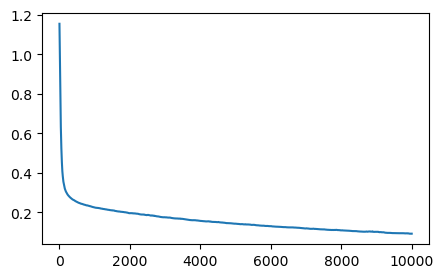

In [16]:
import matplotlib.pyplot as plt

kl_time = [i for i in range(len(KL_list))]
plt.figure(figsize=(5,3))
plt.plot(kl_time, KL_list)
plt.savefig('KL_divergence 0&1')
plt.show()

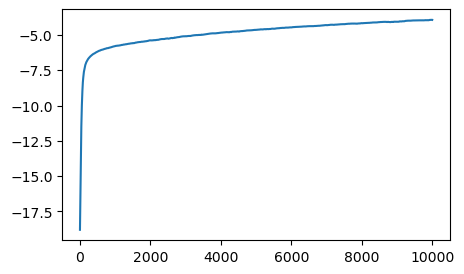

In [17]:
plt.figure(figsize=(5,3))
plt.plot(kl_time, log_LKH_list)
plt.savefig('log_Likelihood 0&1')
plt.show()

In [14]:
acc = 0
train_data = [train_data[i].astype(int) for i in range(len(train_data))]
for i in range(len(train_data)):
    v0 = train_data[i]
    v0, vk, p_h0_v, p_hk_v = rbm.gibbs_sampling(v0)
    
    acc_i = np.sum(np.where(train_data[i]==vk, 1, 0)/len(train_data[i]))
    print('original_data: {}, sampling_data: {}, acc: {}'.format(train_data[i], vk, acc_i))

original_data: [1 1 1 0 0 0 0 0 0], sampling_data: [[1 1 1 0 0 0 0 0 0]], acc: 1.0
original_data: [0 0 0 1 1 1 0 0 0], sampling_data: [[0 0 0 1 1 1 0 0 0]], acc: 1.0
original_data: [0 0 0 0 0 0 1 1 1], sampling_data: [[0 0 0 0 0 0 1 1 0]], acc: 0.8888888888888888
original_data: [1 1 1 1 1 1 0 0 0], sampling_data: [[1 1 1 1 1 1 0 0 0]], acc: 1.0
original_data: [1 1 1 0 0 0 1 1 1], sampling_data: [[1 1 1 1 0 0 1 0 0]], acc: 0.6666666666666666
original_data: [0 0 0 1 1 1 1 1 1], sampling_data: [[0 0 0 1 1 1 0 0 0]], acc: 0.6666666666666666
original_data: [1 0 0 1 0 0 1 0 0], sampling_data: [[1 0 0 1 0 0 0 0 0]], acc: 0.8888888888888888
original_data: [0 1 0 0 1 0 0 1 0], sampling_data: [[0 1 0 0 1 0 0 1 0]], acc: 1.0
original_data: [0 0 1 0 0 1 0 0 1], sampling_data: [[0 0 1 0 0 1 0 0 1]], acc: 1.0
original_data: [1 1 0 1 1 0 1 1 0], sampling_data: [[1 1 0 1 1 0 1 1 0]], acc: 1.0
original_data: [1 0 1 1 0 1 1 0 1], sampling_data: [[1 0 1 1 0 1 0 0 1]], acc: 0.8888888888888888
original_dat

<AxesSubplot:>

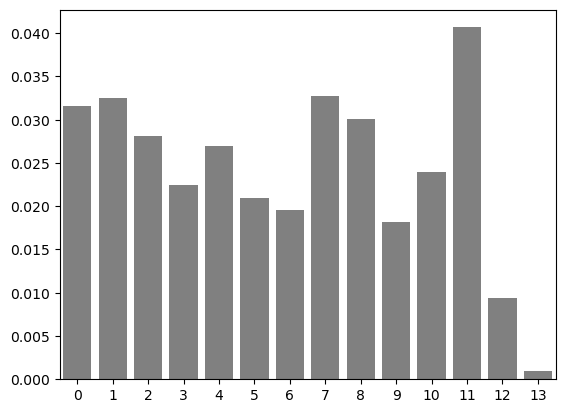

In [15]:
import seaborn as sns
sns.barplot(data = probability_list, color='Grey')

In [ ]:
with open("3x3.txt") as text01, open("pn3x3.txt", "w+") as text11:
    data = text01.readlines()
    for i in range(len(data)):
        raw_data = data[i][:-1].split(" ")
        for j in range(len(raw_data)):
            raw_data[j] = float(raw_data[j])
            if raw_data[j] == 0:
                raw_data[j] = -1.0
            text11.write(str(raw_data[j]))
            text11.write(str(" "))
        text11.write("\n")